In [1]:
import matplotlib.pyplot as plt
from IPython.display import Audio

型下载

In [2]:
from modelscope import snapshot_download
model_dir = snapshot_download('mirror013/ChatTTS')

2024-06-10 04:24:40,181 - modelscope - INFO - PyTorch version 2.1.0 Found.
2024-06-10 04:24:40,182 - modelscope - INFO - Loading ast index from /Users/charslee/.cache/modelscope/ast_indexer
2024-06-10 04:24:40,232 - modelscope - INFO - Loading done! Current index file version is 1.13.3, with md5 8e4efa69aee288a831cd8dd27b421a93 and a total number of 972 components indexed
/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


加载模型

In [4]:
import ChatTTS
chat = ChatTTS.Chat()
chat.load_models(
    source="local",
    local_path=model_dir,
    device='cpu',
    compile=False,
)

INFO:ChatTTS.core:Load from local: /Users/charslee/.cache/modelscope/hub/mirror013/ChatTTS
INFO:ChatTTS.core:vocos loaded.
INFO:ChatTTS.core:dvae loaded.
INFO:ChatTTS.core:gpt loaded.
INFO:ChatTTS.core:decoder loaded.
INFO:ChatTTS.core:tokenizer loaded.
INFO:ChatTTS.core:All initialized.


推理并返回梅尔声谱图

In [5]:
mel_spec = chat.infer(
    text='你好，我是Chat T T S。',
    use_decoder=False,
    return_mel_spec=True,
)[0]
print(mel_spec.shape)


INFO:ChatTTS.core:All initialized.
  7%|▋         | 149/2048 [00:06<01:25, 22.20it/s]


torch.Size([1, 100, 298])


绘制梅尔声谱图

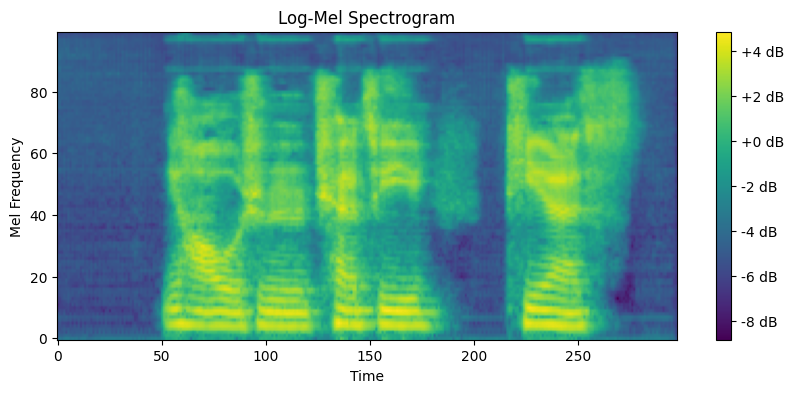

In [6]:
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec[0].detach().numpy(), aspect='auto', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [10]:
import numpy as np
import librosa
# 这里我们取第一个 batch 的 Mel 频谱图
mel_spectrogram = mel_spec[0].detach().numpy()

# 使用 librosa 的 mel_to_audio 函数将 Mel 频谱图转换为音频信号
audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram,
                                             sr=24000,
                                             n_fft=1024,
                                             win_length=None,
                                             hop_length=256)

# 播放音频
Audio(audio, rate=24000, autoplay=False)

In [11]:
# 使用vocoas 将Mel频谱图还原为音频信号
import torch
from vocos import Vocos

model = Vocos.from_hparams("/private/tmp/ChatTTS/config/vocos.yaml").eval()
model.load_state_dict(torch.load("/private/tmp/ChatTTS/asset/Vocos.pt"))

audio = model.decode(mel_spec,sr=24000)
Audio(audio.squeeze(0).squeeze(0).numpy(),rate=24000)

In [ ]:
# 获取中间结果
infer_middle_result = chat.infer(
    text='你好，我是ChatTTS。', 
    skip_refine_text=True, 
    refine_text_only=True, 
    return_infer_token=True
)

In [ ]:
for key,value in infer_middle_result.items():
    print(f"+----------{key}------------+")
    for v in value:
        if v is None: continue
        print(f"{v.shape}")
    print(f"")

In [ ]:
print(infer_middle_result['hiddens'][0].shape)
print(infer_middle_result['hiddens'][0][None].permute(0,2,1).shape)

In [ ]:
# 保存chatts.npy
import numpy as np
print(infer_middle_result['hiddens'][0][None].permute(0,2,1).shape)
print(infer_middle_result['hiddens'][0][None].permute(0,2,1).dtype)
np.save("chatts.npy", infer_middle_result['hiddens'][0][None].permute(0,2,1).cpu().numpy())

# fish-speech 音色迁移
2024-06-02 20:23:02.733 | INFO     | __main__:load_model:39 - Restored model from checkpoint
2024-06-02 20:23:02.740 | INFO     | __main__:main:96 - Processing precomputed indices from codes_0.npy
2024-06-02 20:23:02.747 | INFO     | __main__:main:100 - indices shape: torch.Size([2, 81])
2024-06-02 20:23:03.880 | INFO     | __main__:main:114 - Loaded reference audio from zhongli.ogg, shape: torch.Size([435207])
2024-06-02 20:23:13.913 | INFO     | __main__:main:126 - Encoded text: torch.Size([1, 25])
2024-06-02 20:23:13.915 | INFO     | __main__:main:130 - indices shape: torch.Size([2, 81])      feature_lengths:tensor([81], device='cuda:0')
2024-06-02 20:23:14.220 | INFO     | __main__:main:134 - Restored VQ features: torch.Size([1, 768, 324])
2024-06-02 20:23:14.773 | INFO     | __main__:main:144 - Generated audio: torch.Size([1, 1, 165888]), equivalent to 3.76 seconds
2024-06-02 20:23:14.773 | INFO     | __main__:main:150 - fake_audio shape: (165888,)
2024-06-02 20:23:14.778 | INFO     | __main__:main:152 - Saved audio to generate0.wav

# dvae 模型架构
```
DVAE(
  (decoder): DVAEDecoder(
    (conv_in): Sequential(
      (0): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): GELU(approximate='none')
      (2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (decoder_block): ModuleList(
      (0-11): 12 x ConvNeXtBlock(
        (dwconv): Conv1d(256, 256, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,), groups=256)
        (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
    (conv_out): Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False)
  )
  (out_conv): Conv1d(512, 100, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (vq_layer): GFSQ(
    (quantizer): GroupedResidualFSQ(
      (rvqs): ModuleList(
        (0-1): 2 x ResidualFSQ(
          (project_in): Linear(in_features=512, out_features=4, bias=True)
          (project_out): Linear(in_features=4, out_features=512, bias=True)
          (layers): ModuleList(
            (0-1): 2 x FSQ(
              (project_in): Identity()
              (project_out): Identity()
            )
          )
        )
      )
    )
  )
)
```